In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
from tqdm import tqdm

# 2- Extracting data from the HWSDv1.2 selection of data [Here](https://www.fao.org/soils-portal/data-hub/soil-maps-and-databases/harmonized-world-soil-database-v12/en/)

### As the yield data of AGRESTE is available at the department level, we aim to asignate a department to each HWSDB point

In [2]:
depts = gpd.read_file("src/contour-des-departements.geojson")

In [3]:
depts.head()

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


In [4]:
# Put all the geometry in a polygon format
multi = depts[depts.geometry.type == 'MultiPolygon']
single = depts[depts.geometry.type == 'Polygon']

depts = pd.concat([single, multi.explode(index_parts=True).reset_index(drop=True)])

In [5]:
depts.geometry.type.unique()

array(['Polygon'], dtype=object)

## Soil qualitative qualities for crop production

Note that the classes used in the Soil Quality evaluation are:

**1:** No or slight limitations

**2:** Moderate limitations

**3:** Sever limitations

**4:** Very severe limitations

**5:** Mainly non-soil

**6:** Permafrost area

**7:** Water bodies 

In [6]:
soil_qualities_list = [("src/sq1.asc", "Nutrient availability (SQ1)"),
                       ("src/sq2.asc", "Nutrient retention capacity (SQ2)"),
                       ("src/sq3.asc", "Rooting conditions (SQ3)"),
                       ("src/sq4.asc", "Oxygen availability to roots (SQ4)"),
                       ("src/sq5.asc", "Excess salts (SQ5)"),
                       ("src/sq6.asc", "Toxicity (SQ6)"),
                       ("src/sq7.asc", "Workability (SQ7)"),
                       ]

In [7]:
def extract_data_ascii_to_pd(file_path, limits_lon = (-5, 10) , limits_lat = (41, 51), float_matrix = False):
    print(f"Extracting data from {file_path}")
    data_type = np.float32 if float_matrix else np.int8 
    with open(file_path, "r") as file:
        ncol, nrow, xllcorner, yllcorner = (int(file.readline().split()[1]),
                                        int(file.readline().split()[1]),
                                        int(file.readline().split()[1]),
                                        int(file.readline().split()[1])
                                        )
        cellsize = float(file.readline().split()[1])
        M = dok_matrix((nrow, ncol), dtype=data_type)
        # read the first line
        line = file.readline()
        for i in tqdm(range(nrow)):
            M[i] = np.array(line.split()).astype(data_type)
            line = file.readline()
    
    dict_quality = {'lon': list(),
                    'lat': list(),
                    'value': list()}
    for i in tqdm(M.items()):
        lon, lat = (xllcorner + i[0][1]*cellsize), (abs(yllcorner) - i[0][0]*cellsize)
        dict_quality['lon'].append(lon)
        dict_quality['lat'].append(lat)
        dict_quality['value'].append(i[1])
    
    df = pd.DataFrame(dict_quality)
    df = df[(df['lon']>limits_lon[0]) & (df['lon']<limits_lon[1])]
    df = df[(df['lat']>limits_lat[0]) & (df['lat']<limits_lat[1])]
    df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326")
    df = gpd.sjoin(df, depts[['geometry', 'code']], how='left', predicate='within')
    # Rename the joined column for clarity
    df = df.rename(columns={'code': 'dept'})
    df.drop(columns=['index_right', 'geometry'], inplace=True)
    df.dropna(subset=['dept'], inplace=True)

    return df

In [8]:
soil_quality_dfs = dict()
for i in soil_qualities_list:
    str_key = i[1].split()[-1][1:-1]
    soil_quality_dfs[str_key] = extract_data_ascii_to_pd(i[0])

Extracting data from src/sq1.asc


  0%|          | 0/2160 [00:00<?, ?it/s]

100%|██████████| 2205065/2205065 [00:00<00:00, 2549105.48it/s]


Extracting data from src/sq2.asc


100%|██████████| 2205065/2205065 [00:00<00:00, 2651419.39it/s]


Extracting data from src/sq3.asc


100%|██████████| 2205065/2205065 [00:00<00:00, 2672407.40it/s]


Extracting data from src/sq4.asc


100%|██████████| 2205065/2205065 [00:00<00:00, 2649150.13it/s]


Extracting data from src/sq5.asc


100%|██████████| 2205065/2205065 [00:00<00:00, 2615922.11it/s]


Extracting data from src/sq6.asc


100%|██████████| 2205065/2205065 [00:00<00:00, 2641686.34it/s]


Extracting data from src/sq7.asc


100%|██████████| 2205065/2205065 [00:00<00:00, 2654822.96it/s]


In [9]:
soil_quality_dfs[list(soil_quality_dfs.keys())[0]]["value"].unique()

array([1, 2, 4, 3, 5, 6, 7], dtype=int8)

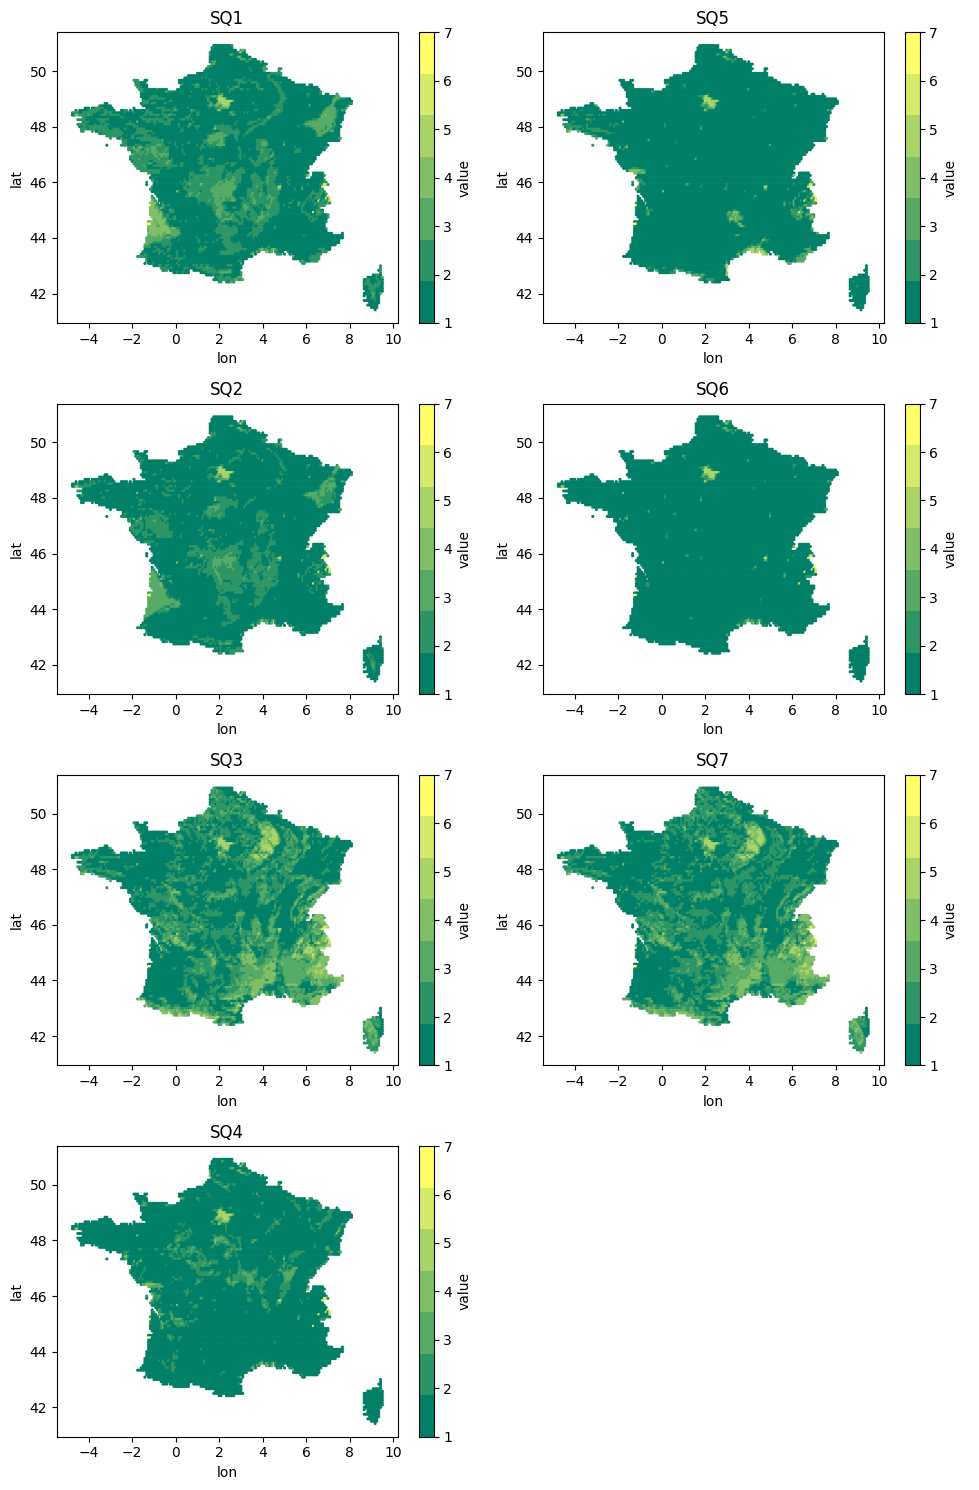

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(10, 15))
cmap = plt.get_cmap("summer", 7)
ax_x = 0
ax_y = 0
for i in list(soil_quality_dfs.keys()):        
    soil_quality_dfs[i].plot(kind="scatter", x="lon", y="lat", c="value", cmap=cmap, s=1.5, ax=axs[ax_x, ax_y], title=i)
    if ax_x < 3:
        ax_x+=1
    else:
        ax_x = 0
        ax_y += 1
fig.tight_layout()
plt.axis('off')
plt.show()

In [11]:
soil_quality_df_final = soil_quality_dfs["SQ1"].groupby("dept").agg({"value": lambda x: x.value_counts().index[0]})
soil_quality_df_final.rename(columns={"value": "SQ1"}, inplace=True)
for key, df in list(soil_quality_dfs.items())[1:]:
    df = df.groupby("dept").agg({"value": lambda x: x.value_counts().index[0]})
    df.rename(columns={"value": key}, inplace=True)
    soil_quality_df_final = pd.merge(soil_quality_df_final, df, on="dept")

In [12]:
print(soil_quality_df_final.shape)
soil_quality_df_final.head()

(96, 7)


,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
dept,,,,,,,
01,1,1,1,1,1,1,1
02,1,1,2,1,1,1,2
03,1,1,1,1,1,1,1
04,1,1,3,1,1,1,3
05,1,1,3,1,1,1,3


In [13]:
tmp_plot = pd.merge(depts, soil_quality_df_final["SQ1"], left_on="code", right_on="dept")
tmp_plot["SQ1"].unique()

array([1, 2, 3, 5, 4], dtype=int8)

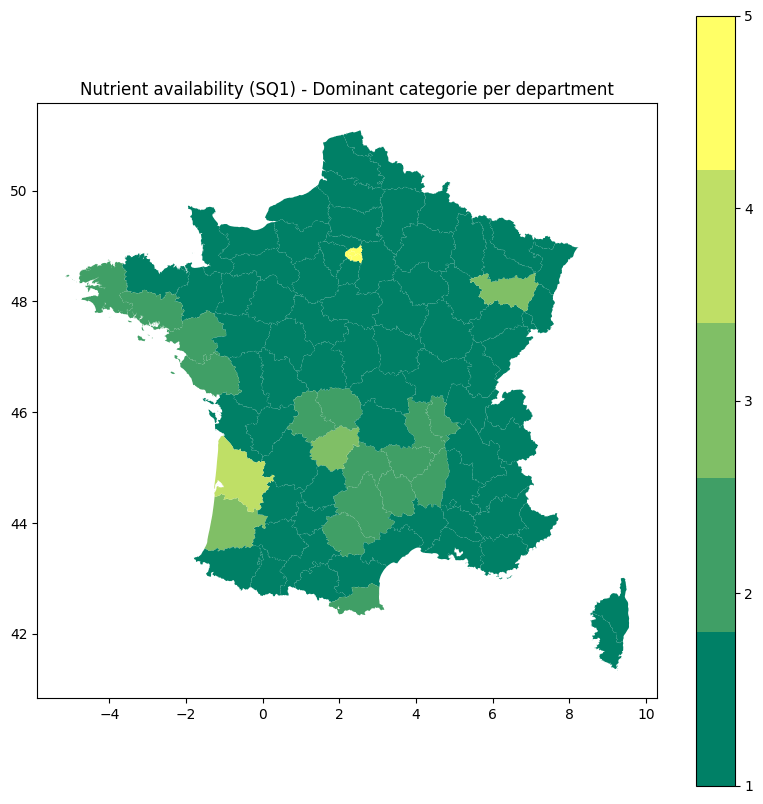

In [14]:
cmap2 = plt.get_cmap("summer", 5)
fig = tmp_plot.plot(column="SQ1", cmap=cmap2, figsize=(10, 10))
# color bar showing only the categories present in the data
cbar = plt.colorbar(fig.collections[0], ticks=tmp_plot["SQ1"].unique())
plt.title("Nutrient availability (SQ1) - Dominant categorie per department")
plt.show()

In [15]:
soil_quality_df_final.to_csv("inter_data/soil_quality_df_final.csv")

## Land use and land cover

In [16]:
land_use_list = [("src/CULTRF_2000.asc", "CULTRF_2000"),
                 ("src/CULTIR_2000.asc", "CULTIR_2000"),
                 ("src/CULT_2000.asc", "CULT_2000"),
                 ("src/FOR_2000.asc", "FOR_2000"),
                 ("src/NVG_2000.asc", "NVG_2000"),
                 ("src/WAT_2000.asc", "WAT_2000"),
                 ("src/GRS_2000.asc", "GRS_2000"),
                 ("src/URB_2000.asc", "URB_2000"),]

In [17]:
land_use_dfs = dict()
for i in land_use_list:
    land_use_dfs[i[1]] = extract_data_ascii_to_pd(i[0], float_matrix=True)

Extracting data from src/CULTRF_2000.asc


100%|██████████| 973739/973739 [00:00<00:00, 2644198.35it/s]


Extracting data from src/CULTIR_2000.asc


100%|██████████| 496539/496539 [00:00<00:00, 2631853.29it/s]


Extracting data from src/CULT_2000.asc


100%|██████████| 1067259/1067259 [00:00<00:00, 2545570.53it/s]


Extracting data from src/FOR_2000.asc


100%|██████████| 1472823/1472823 [00:00<00:00, 2614953.76it/s]


Extracting data from src/NVG_2000.asc


100%|██████████| 1077061/1077061 [00:00<00:00, 2753956.42it/s]


Extracting data from src/WAT_2000.asc


100%|██████████| 269216/269216 [00:00<00:00, 2313198.04it/s]


Extracting data from src/GRS_2000.asc


100%|██████████| 2180357/2180357 [00:00<00:00, 2623693.39it/s]


Extracting data from src/URB_2000.asc


100%|██████████| 1502372/1502372 [00:00<00:00, 2623995.67it/s]


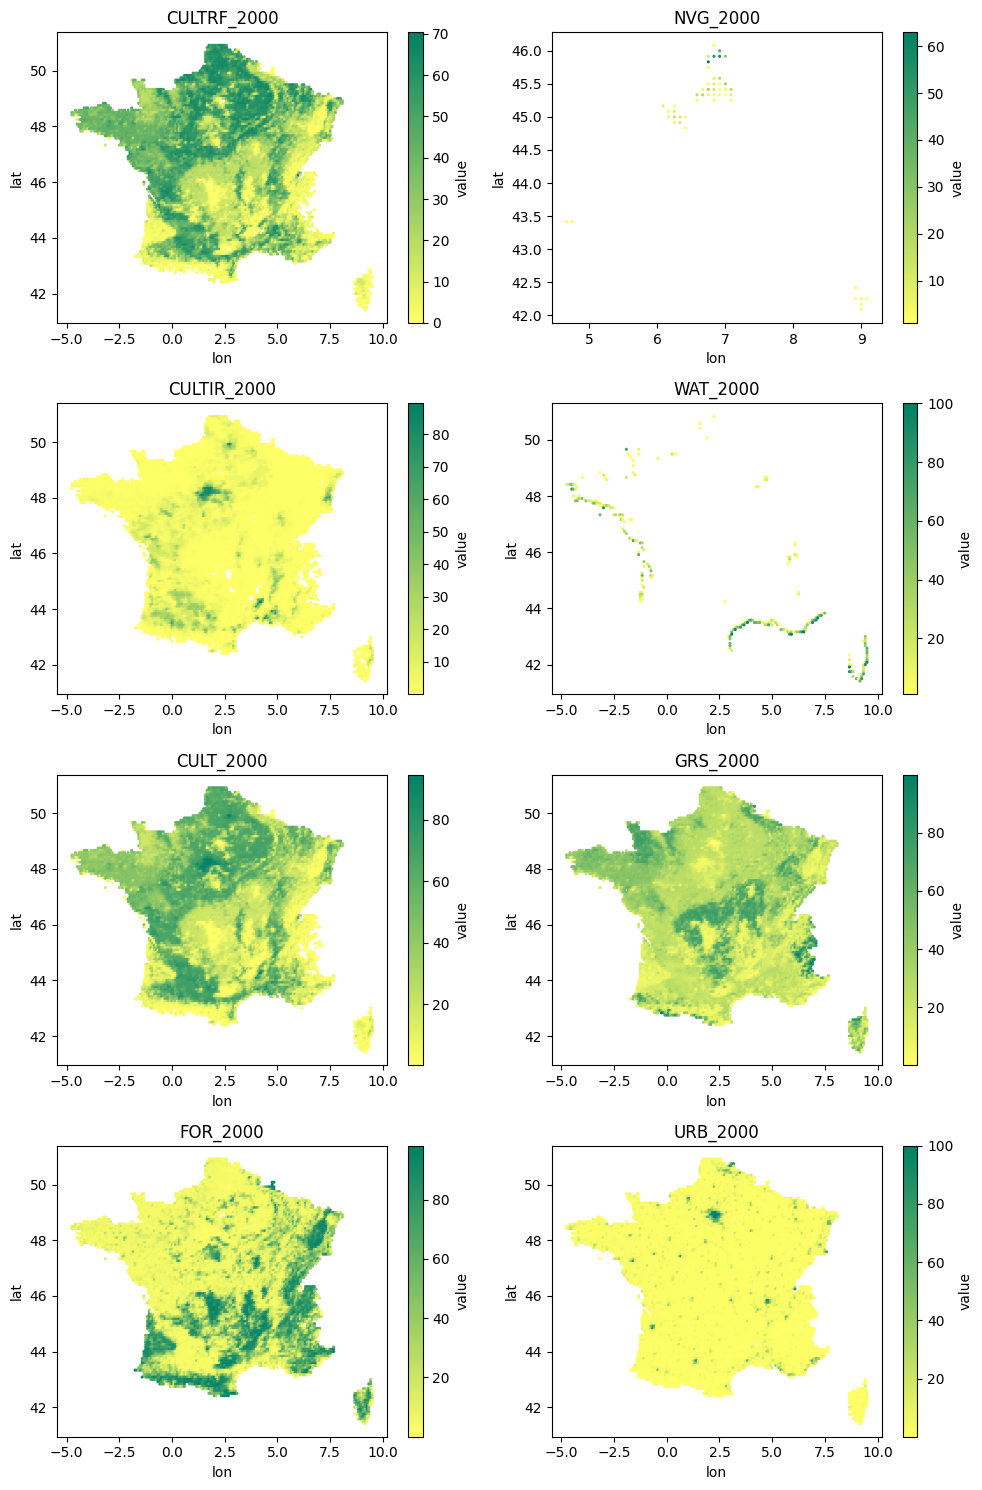

In [18]:
fig, axs = plt.subplots(4, 2, figsize=(10, 15))
ax_x = 0
ax_y = 0
for i in list(land_use_dfs.keys()):        
    land_use_dfs[i].plot(kind="scatter", x="lon", y="lat", c="value", cmap="summer_r", s=1.5, ax=axs[ax_x, ax_y], title=i)
    if ax_x < 3:
        ax_x+=1
    else:
        ax_x = 0
        ax_y += 1
fig.tight_layout()
plt.show()

In [19]:
land_use_dfs.keys()

dict_keys(['CULTRF_2000', 'CULTIR_2000', 'CULT_2000', 'FOR_2000', 'NVG_2000', 'WAT_2000', 'GRS_2000', 'URB_2000'])

In [20]:
land_use_df_final = land_use_dfs["CULTRF_2000"].groupby("dept").agg({"value": "mean"})
land_use_df_final.rename(columns={"value": "CULTRF_2000"}, inplace=True)
for key, df in list(land_use_dfs.items())[1:]:
    df = df.groupby("dept").agg({"value": "mean"})
    df.rename(columns={"value": key}, inplace=True)
    land_use_df_final = pd.merge(land_use_df_final, df, how="outer",on="dept")

In [21]:
land_use_df_final.head()

,CULTRF_2000,CULTIR_2000,CULT_2000,FOR_2000,NVG_2000,WAT_2000,GRS_2000,URB_2000
dept,,,,,,,,
01,24.909853,4.283126,28.847866,42.696304,NaN,4.569533,23.964094,4.395725
02,50.851418,4.495917,55.347332,10.268482,NaN,NaN,31.629292,2.754892
03,23.656496,2.579530,26.236027,14.089846,NaN,NaN,57.834843,2.049171
04,20.452394,3.656260,23.146242,49.991306,NaN,NaN,28.457148,0.874197
05,16.766521,4.180267,15.593896,44.879406,8.0,5.492200,41.458084,0.859865


In [22]:
tmp_plot = pd.merge(depts, land_use_df_final["CULTRF_2000"], left_on="code", right_on="dept")

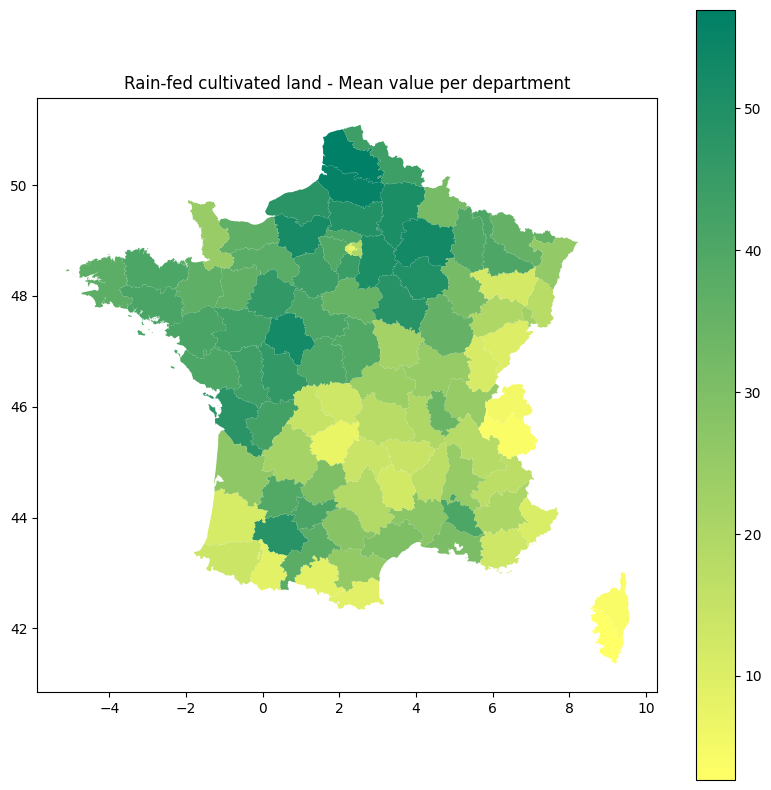

In [23]:
tmp_plot.plot(column="CULTRF_2000", cmap="summer_r", legend=True, figsize=(10, 10),)
plt.title("Rain-fed cultivated land - Mean value per department")
plt.show()

In [24]:
land_use_df_final.to_csv("inter_data/land_use_df_final.csv")

## Slopes and elevation (Not sure if I'm going to use this one ...)